In [1]:
import xarray as xr
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error



2024-12-02 14:50:21.389293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 14:50:21.389347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 14:50:21.389354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 14:50:21.396127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inputDs=xr.open_dataset('/eos/jeodpp/data/projects/AGRI4CAST/MetStats/ozalp/AgERA5_BDAP/RR/AgERA5_1979_2023_rr.nc')

In [3]:
months_ref_t= inputDs.Precipitation_Flux.sel(time=slice('1980-01-01','2023-12-31'))


In [4]:
may_dim_mean=months_ref_t.mean(dim=('lon', 'lat'))


In [5]:
precip_ts=np.array(may_dim_mean)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


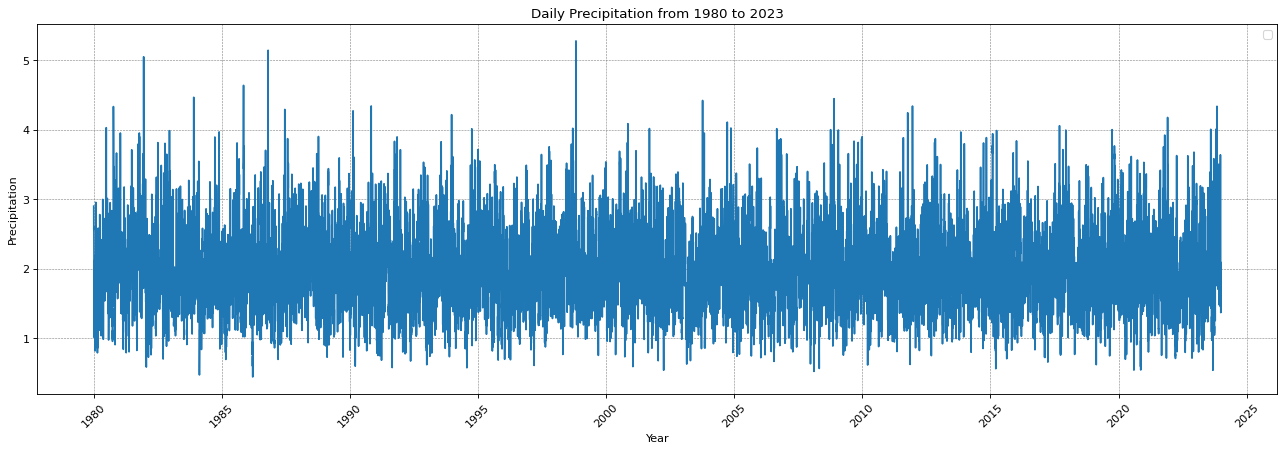

In [6]:
plt.figure(figsize=(20, 6), dpi=80)

may_dim_mean.plot()
plt.title("Daily Precipitation from 1980 to 2023")
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.xticks(rotation=45)  

plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.legend(loc='best')
plt.show()

In [7]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(precip_ts).reshape(-1,1))
df2.shape

(16071, 1)

In [8]:
train_size = int(len(df2)*0.75)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1] 

In [9]:
train_size,test_size

(12053, 4018)

In [10]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [11]:
time_step = 10
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [12]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(12042, 10)
[[0.50831777 0.43871427 0.44732648 ... 0.12144388 0.15639818 0.1165131 ]
 [0.43871427 0.44732648 0.41585386 ... 0.15639818 0.1165131  0.12178034]
 [0.44732648 0.41585386 0.342672   ... 0.1165131  0.12178034 0.1662935 ]
 ...
 [0.29816607 0.3685331  0.36088845 ... 0.2718206  0.31336924 0.33385164]
 [0.3685331  0.36088845 0.45266163 ... 0.31336924 0.33385164 0.41062832]
 [0.36088845 0.45266163 0.20841804 ... 0.33385164 0.41062832 0.2716095 ]]
(4007, 10)
(4007,)


In [13]:
model = Sequential()
model.add(LSTM(150,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(150,return_sequences = True))
model.add(LSTM(150))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

2024-12-02 14:51:33.871730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46511 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 150)           91200     
                                                                 
 lstm_1 (LSTM)               (None, 10, 150)           180600    
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 452551 (1.73 MB)
Trainable params: 452551 (1.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# epoch=300
# batchSize=64
# verbose=1

In [16]:
history=model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 410,batch_size = 64,verbose = 1)


Epoch 1/410


2024-12-02 14:51:39.839671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-12-02 14:51:40.618056: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f12181c02f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-02 14:51:40.618088: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-12-02 14:51:40.625462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-02 14:51:40.791487: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 [==============================] - 8s 15ms/step - loss: 0.0149 - val_loss: 0.0124
Epoch 2/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0097 - val_loss: 0.0076
Epoch 3/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 4/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 6/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 7/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 8/410
189/189 [==============================] - 2s 10ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 9/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 10/410
189/189 [==============================] - 2s 11ms/step - loss: 0.0072 - val_loss

In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

126/126 [==============================] - 0s 4ms/step


In [18]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [19]:
print("Training:",math.sqrt(mean_squared_error(Y_train,train_predict)))
print("Test:",math.sqrt(mean_squared_error(Y_test,test_predict)))

Training: 1.7082972251363546
Test: 1.7368681575260132


In [20]:
look_back = 10


In [21]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [22]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

In [23]:
test_predict.shape

(4007, 1)

In [24]:
len(trainPredictPlot),len(testPredictPlot)

(16071, 16071)

In [39]:
# import matplotlib.pyplot as plt
# from matplotlib import pyplot

# figure(figsize=(20, 6), dpi=80)

# plt.plot(scaler.inverse_transform(df2),color='teal')
# plt.plot(trainPredictPlot,color='y')
# plt.plot(testPredictPlot,color='r')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title("LSTM-AgERA5-RR from 1980 to 2023")
# plt.legend(['original', 'train','test'], loc='best')


# plt.show()

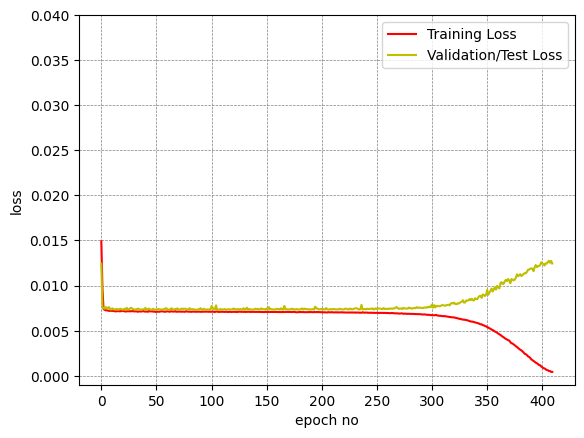

In [40]:
plt.plot(history.history['loss'], label='Training Loss',color='r')
plt.plot(history.history['val_loss'], label='Validation/Test Loss', color='y')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.ylim(-0.001, 0.04)
plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.legend()
pyplot.legend()
pyplot.show()

In [32]:
# plt.figure(figsize=(20, 6), dpi=80)

# # Plot the actual test data (inverse transformed)
# plt.plot(scaler.inverse_transform(test_data), color='teal', label='Actual Test Data')

# # Plot the test predictions
# plt.plot(testPredictPlot[len(train_predict)+(look_back)*2 + 1: len(df2) - 1,:], color='red', label='Predicted Test Data')

# # Add titles and labels
# plt.title("LSTM Test Predictions vs Actual Test Data")
# plt.xlabel('Time Steps')
# plt.ylabel('Precipitation Flux')
# plt.legend(loc='best')

# plt.show()

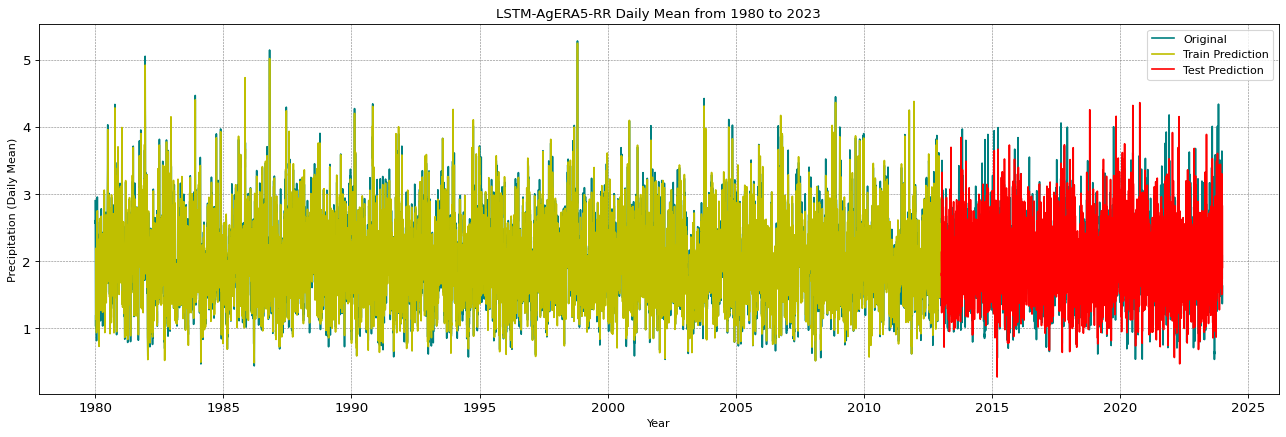

In [36]:
dates = pd.date_range(start='1980-01-01', end='2023-12-31', freq='D')

original_df = pd.DataFrame(data=scaler.inverse_transform(df2), index=dates, columns=['Precipitation'])

trainPredictPlot_df = pd.DataFrame(data=trainPredictPlot, index=dates, columns=['Train Prediction'])
testPredictPlot_df = pd.DataFrame(data=testPredictPlot, index=dates, columns=['Test Prediction'])

plt.figure(figsize=(20, 6), dpi=80)

#original precipitation data
plt.plot(original_df.index, original_df['Precipitation'], color='teal', label='Original')

#training predictions
plt.plot(trainPredictPlot_df.index, trainPredictPlot_df['Train Prediction'], color='y', label='Train Prediction')

#testing predictions
plt.plot(testPredictPlot_df.index, testPredictPlot_df['Test Prediction'], color='r', label='Test Prediction')

plt.title("LSTM-AgERA5-RR Daily Mean from 1980 to 2023")
plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Year')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Precipitation (Daily Mean)')
plt.legend(loc='best')
plt.show()

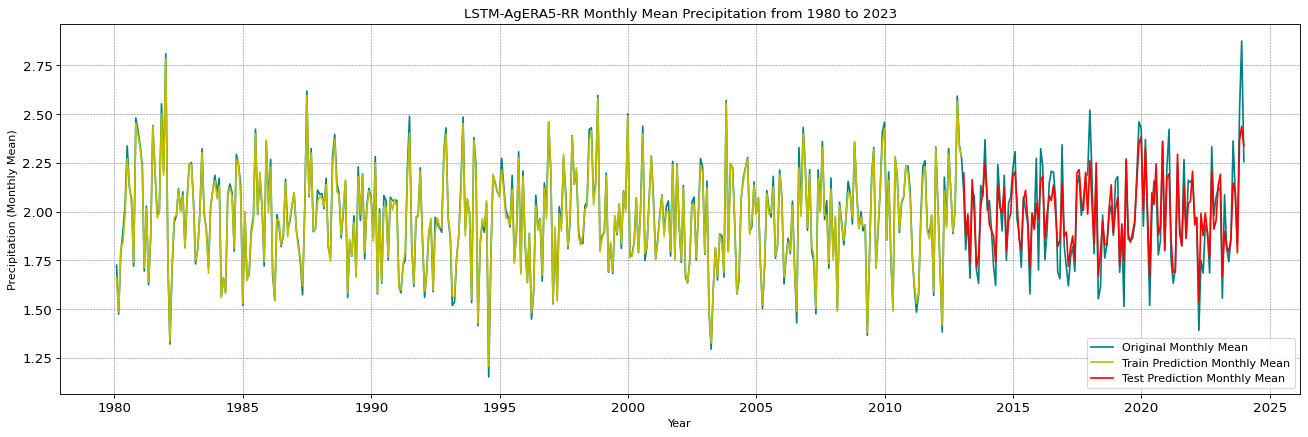

In [37]:
dates = pd.date_range(start='1980-01-01', end='2023-12-31', freq='D')

original_df = pd.DataFrame(data=scaler.inverse_transform(df2), index=dates, columns=['Precipitation'])

# Resample the original data to monthly frequency
monthly_original_df = original_df.resample('M').mean()

# Create DataFrames for the train and test predictions
trainPredictPlot_df = pd.DataFrame(data=trainPredictPlot, index=dates, columns=['Train Prediction'])
testPredictPlot_df = pd.DataFrame(data=testPredictPlot, index=dates, columns=['Test Prediction'])

# Resample the training and testing predictions to monthly frequency
monthly_trainPredictPlot_df = trainPredictPlot_df.resample('M').mean()
monthly_testPredictPlot_df = testPredictPlot_df.resample('M').mean()

plt.figure(figsize=(20, 6), dpi=80)

plt.plot(monthly_original_df.index, monthly_original_df['Precipitation'], color='teal', label='Original Monthly Mean')

plt.plot(monthly_trainPredictPlot_df.index, monthly_trainPredictPlot_df['Train Prediction'], color='y', label='Train Prediction Monthly Mean')

plt.plot(monthly_testPredictPlot_df.index, monthly_testPredictPlot_df['Test Prediction'], color='r', label='Test Prediction Monthly Mean')

plt.title("LSTM-AgERA5-RR Monthly Mean Precipitation from 1980 to 2023")
plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Year')
plt.ylabel('Precipitation (Monthly Mean)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best')
#plt.xticks(rotation=45)  
plt.show()